In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from pyDOE import lhs   # Latin Hypercube Sampling

## 1D Viscous Buergers' Equation

$$\frac{\partial u}{\partial t} + u\frac{\partial u}{\partial t} - \nu\frac{\partial^2 u}{\partial x^2} = 0,\quad \nu = \frac{0.01}{\pi}$$
$$u(0, x) = -\sin(\pi x)$$
$$u(t, -1) = u(t, 1) = 0$$

### Training Points - Sampling

In [ ]:
t_min, t_max = 0, 0.99
x_min, x_max = -1, 1

n_domain = 10000        # Number of points in the domain
n_ic = 200              # Number of initial condition points
n_bc = 100              # Number of boundary condition points

## Domain: u_t + u*u_x - (0.01/pi)*u_xx = 0 for u(t, x)
lb, ub = np.array([t_min, x_min]), np.array([t_max, x_max])
domain = lhs(2, n_domain) * (ub - lb) + lb
t, x = domain[:, 0], domain[:, 1]

## Initial condition: u(0, x) = -sin(pi * x)
x_ic = lhs(1, n_ic)*(x_max - x_min) + x_min
t_ic = np.full_like(x_ic, 0)
u_ic = -np.sin(np.pi * x_ic)

## Boundary condition: u(t, x_min) = 0
t_bc1 = lhs(1, n_bc)*(t_max - t_min) + t_min
x_bc1 = np.full_like(t_bc1, x_min)
u_bc1 = np.full_like(t_bc1, 0)

## Boundary condition: u(t, x_max) = 0
t_bc2 = lhs(1, n_bc)*(t_max - t_min) + t_min
x_bc2 = np.full_like(t_bc2, x_max)
u_bc2 = np.full_like(t_bc2, 0)

In [ ]:
fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(t, x, 'ko', ms=1)           # Domain points
ax.plot(t_ic, x_ic, 'ro', ms=3)     # Initial condition points
ax.plot(t_bc1, x_bc1, 'bo', ms=3)   # Boundary condition points at x_min
ax.plot(t_bc2, x_bc2, 'go', ms=3)   # Boundary condition points at x_max
ax.set_xlabel('t')
ax.set_ylabel('x')
ax.set_title('Training Points for PDE')
fig.tight_layout()
plt.show()

### Modeling

In [ ]:
class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(2, 20),  nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 1),
        )

    def forward(self, t, x):
        tx = torch.concat([t, x], dim=1)  # Concatenate time and space
        return self.layers(tx)

def gradient(y, x):
    return torch.autograd.grad(y, x, grad_outputs=torch.ones_like(y),
                               create_graph=True, retain_graph=True)[0]

def residual_loss(model, t, x):
    t.requires_grad = True
    x.requires_grad = True

    u = model(t, x)
    u_t = gradient(u, t)
    u_x = gradient(u, x)
    u_xx = gradient(u_x, x)

    residual = u_t + u*u_x - (0.01/np.pi)*u_xx
    return torch.mean(residual**2)

def mse_loss(model, t, x, u):
    u_pred = model(t, x)
    return torch.mean((u_pred - u)**2)

def tensor(x):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    return torch.tensor(x).float().view(-1, 1).to(device)

### Training

In [ ]:
n_epochs = 10000
learning_rate = 1e-3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PINN().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.95)

losses = {}
for epoch in range(1, n_epochs + 1):
    model.train()
    optimizer.zero_grad()

    losses["pde"] = residual_loss(model, tensor(t), tensor(x))
    losses["ic"]  = mse_loss(model, tensor(t_ic), tensor(x_ic), tensor(u_ic))
    losses["bc1"] = mse_loss(model, tensor(t_bc1), tensor(x_bc1), tensor(u_bc1))
    losses["bc2"] = mse_loss(model, tensor(t_bc2), tensor(x_bc2), tensor(u_bc2)) 
    loss = losses["pde"] + losses["ic"] + losses["bc1"] + losses["bc2"]

    loss.backward()
    optimizer.step()
    scheduler.step()
    
    if epoch % (n_epochs // 10) == 0:
        print(f"[{epoch:5d}/{n_epochs}] "
              f"losses: {loss.item():.3e} (lr: {scheduler.get_last_lr()[0]:.2e}) "
              f"pde: {losses['pde'].item():.3e} "
              f"ic: {losses['ic'].item():.3e} "
              f"bc1: {losses['bc1'].item():.3e} "
              f"bc2: {losses['bc2'].item():.3e}")

[ 1000/10000] losses: 1.048e-01 (lr: 9.50e-04) pde: 4.301e-02 ic: 6.032e-02 bc1: 6.638e-04 bc2: 8.575e-04
[ 2000/10000] losses: 8.940e-02 (lr: 9.02e-04) pde: 3.533e-02 ic: 5.329e-02 bc1: 5.496e-04 bc2: 2.291e-04
[ 3000/10000] losses: 7.675e-02 (lr: 8.57e-04) pde: 2.984e-02 ic: 4.675e-02 bc1: 9.819e-05 bc2: 5.893e-05
[ 4000/10000] losses: 2.833e-02 (lr: 8.15e-04) pde: 1.526e-02 ic: 1.296e-02 bc1: 6.046e-05 bc2: 5.914e-05
[ 5000/10000] losses: 8.719e-03 (lr: 7.74e-04) pde: 5.648e-03 ic: 3.020e-03 bc1: 3.621e-05 bc2: 1.451e-05
[ 6000/10000] losses: 4.970e-03 (lr: 7.35e-04) pde: 3.445e-03 ic: 1.499e-03 bc1: 1.836e-05 bc2: 7.064e-06
[ 7000/10000] losses: 3.678e-03 (lr: 6.98e-04) pde: 2.474e-03 ic: 1.183e-03 bc1: 1.408e-05 bc2: 7.637e-06
[ 8000/10000] losses: 2.862e-03 (lr: 6.63e-04) pde: 1.900e-03 ic: 9.431e-04 bc1: 1.134e-05 bc2: 7.159e-06
[ 9000/10000] losses: 2.248e-03 (lr: 6.30e-04) pde: 1.483e-03 ic: 7.495e-04 bc1: 8.779e-06 bc2: 7.002e-06
[10000/10000] losses: 1.763e-03 (lr: 5.99e-04)

### Evaluation

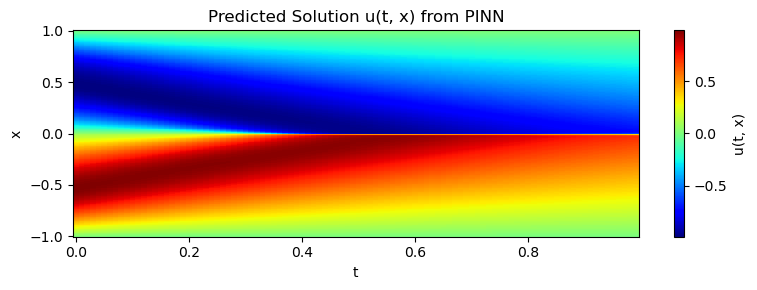

In [60]:
t_test = np.linspace(0, 0.99, 100)
x_test = np.linspace(-1, 1, 256)
T_test, X_test = np.meshgrid(t_test, x_test)

with torch.no_grad():
    model.eval()
    u_pred = model(tensor(T_test.flatten()), tensor(X_test.flatten()))

U_pred = u_pred.cpu().numpy().flatten().reshape(256, 100)

# Plotting the predicted solution
fig, ax = plt.subplots(figsize=(8, 3))
pcolor = ax.pcolormesh(T_test, X_test, U_pred, cmap='jet', shading='auto')
ax.set_xlabel('t')
ax.set_ylabel('x')
ax.set_title('Predicted Solution u(t, x) from PINN')
fig.colorbar(pcolor, ax=ax, label='u(t, x)', )
fig.tight_layout()
plt.show()

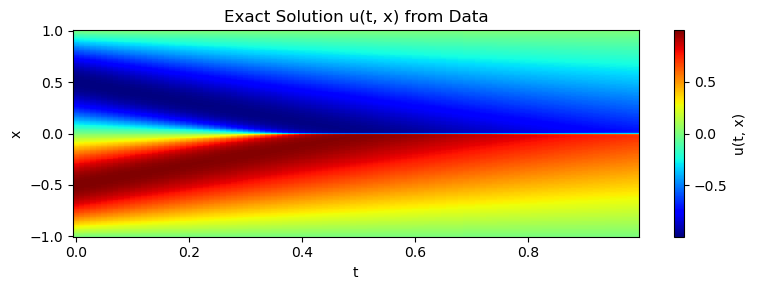

In [61]:
from scipy.io import loadmat

data = loadmat('burgers_shock.mat')
t_data = data['t'].flatten()    # (100,)
x_data = data['x'].flatten()    # (256,)
U_data = data['usol']           # (256, 100)
T_data, X_data = np.meshgrid(t_data, x_data)

# Plotting the original data
fig, ax = plt.subplots(figsize=(8, 3))
pcolor = ax.pcolormesh(T_data, X_data, U_data, cmap='jet', shading='auto')
ax.set_xlabel('t')
ax.set_ylabel('x')
ax.set_title('Exact Solution u(t, x) from Data')
fig.colorbar(pcolor, ax=ax, label='u(t, x)', )
fig.tight_layout()
plt.show()

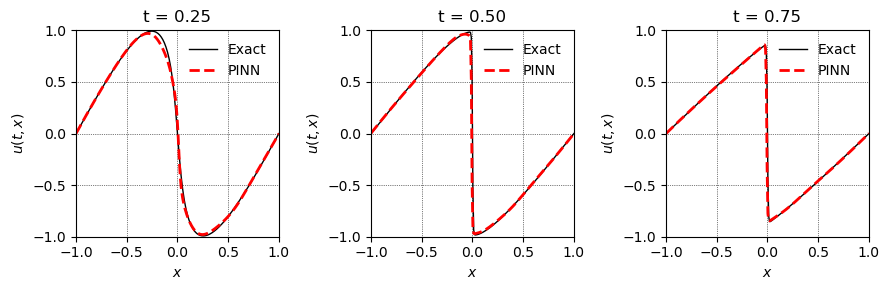

In [68]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(9, 3))

for t, ax in zip((25, 50, 75), (ax1, ax2, ax3)):
    ax.plot(x_data, U_data[:, t], 'k-',  lw=1, label='Exact')
    ax.plot(x_test, U_pred[:, t], 'r--', lw=2, label='PINN')   
    ax.set_title(f't = {t_data[t]:.2f}')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u(t, x)$')
    ax.set_xlim(-1, 1); ax.set_xticks([-1, -0.5, 0, 0.5, 1])
    ax.set_ylim(-1, 1); ax.set_yticks([-1, -0.5, 0, 0.5, 1])
    ax.grid(color="k", ls=":", lw=0.5)
    ax.legend(frameon=False)

fig.tight_layout()
plt.show()